In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import multiclass_helper as MH
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

Using TensorFlow backend.


# Generamos Dataset

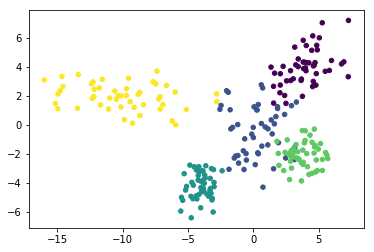

In [167]:
N = 50
mu_1 = [4, 4]
sigma_1 = [[  2,0.8],
           [0.8,  2]]

mu_2 = [0, 0]
sigma_2 = [[  2,  0],
           [  0,  2]]

mu_3 = [-4, -4]
sigma_3 = [[  1,  0],
           [  0,  1]]

mu_4 = [4, -2]
sigma_4 = [[  1,  0],
           [  0,  1]]

mu_5 = [-10, 2]
sigma_5 = [[  10,  0],
           [  0,  1]]


rvs = [
        [mu_1, sigma_1, N], 
        [mu_2, sigma_2, N],
        [mu_3, sigma_3, N],
        [mu_4, sigma_4, N],
        [mu_5, sigma_5, N]
      ]

X, y = MH.generate_dataset(rvs)
y_cat = to_categorical(y)
plt.scatter(X[:,0], X[:,1], c=y, s=20)
plt.show()

# Dividimos en train y test set

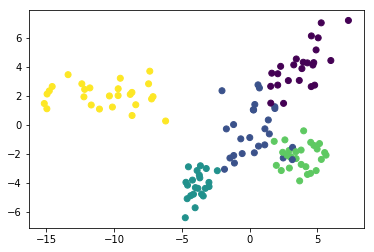

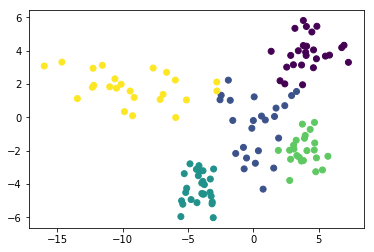

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
plt.scatter(X_train[:,0], X_train[:,1], c=y_train)
plt.show()
plt.scatter(X_test[:,0], X_test[:,1], c=y_test)
plt.show()

In [169]:
from keras.models import Sequential
from keras import optimizers
from keras.layers.core import Dense, Activation
from helper import PlotLosses
from keras.callbacks import ModelCheckpoint
from keras.initializers import RandomNormal
from keras import regularizers

In [170]:
#np.save('X_train_5_clases_1', X_train)
#np.save('X_test_5_clases_1', X_test)
#np.save('y_train_5_clases_1', y_train)
#np.save('y_test_5_clases_1', y_test)

# One vs Rest

Entrenamos tantos modelos de regresión logística como clases tengo. Se calcula una solución de la clase contra todo el resto de las clases

## Regresión Logística

### Definimos un modelo para cada clase

In [171]:
input_features = 2
lambd = 0 #0.001
lr = 0.04 
batch_size = 20
epochs = 200
#selectedOptimizer = optimizers.SGD(lr=lr)
selectedOptimizer = optimizers.adam(lr=lr)

models_vs_rest = []
for i in range(y_train_cat.shape[1]):
    plot_losses = PlotLosses(plot_interval=50, 
                         evaluate_interval=None, 
                         x_val=X_test, 
                         y_val_categorical=y_test_cat[:,i])
    model_vs_rest = Sequential()
    model_vs_rest.add(Dense(1,input_dim=input_features, kernel_regularizer=regularizers.l2(lambd), name="Capa_Oculta"))
    model_vs_rest.add(Activation('sigmoid', name="sigmoid"))
    model_vs_rest.compile(loss = 'binary_crossentropy', optimizer=selectedOptimizer, metrics=['accuracy'])
    models_vs_rest.append(model_vs_rest)

In [172]:
for i in range(y_train_cat.shape[1]):
    print(models_vs_rest[i].evaluate(X,y_cat[:,i]))

 32/250 [==>...........................] - ETA: 2s[3.4954858961105346, 0.32800000000000001]


### Entrenamos cada modelo por separado
La función de costo es simplemente la entropia binaria para cada clase

$J_i = p_i  \log(\hat{p}_i) + (1-p_i) \log(1-\hat{p}_i)$  

donde: 
- $p_i$ solo puede valer 1 o 0. Vale 1 si pertenece a la clase $i$'esima, y 0 si no pertenece
- $\hat{p}_i$ es la estimación de la probabilidad de que $X_i$ pertenezca a la clase

$\hat{y}_i = w_{i,0} + w_{i,1} X_0 + w_{i,2} X_1 $  

$\large \hat{p}_i = \frac{1}{1+e^{-\hat{y}_i}}$

$X_i$'s son los features

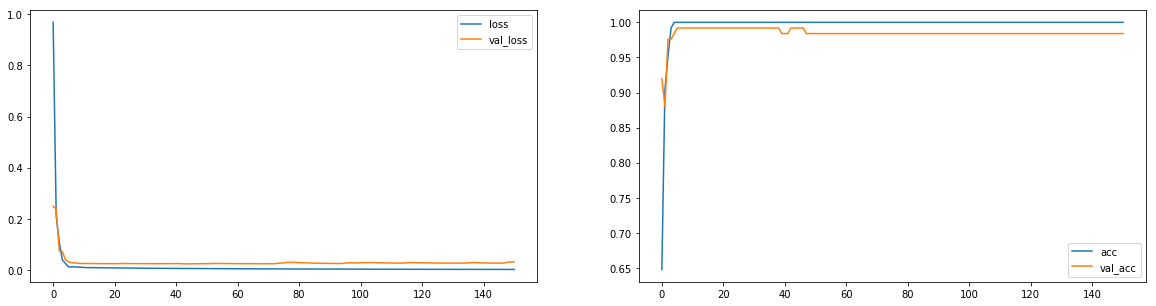

In [78]:
for i in range(y_test_cat.shape[1]):
    models_vs_rest[i].fit(X_train, 
              y_train_cat[:,i], 
              batch_size = batch_size,
              epochs=epochs, 
              verbose=0, 
              validation_data=(X_test, y_test_cat[:,i]), 
              callbacks=[plot_losses],
             )

In [79]:
def predict_proba_one_rest(X, verbose=1):
    proba = np.array([]).reshape(X.shape[0], 0)
    for model in models_vs_rest:
        out = model.predict_proba(X, verbose=verbose)
        proba = np.hstack([proba, out])
    return proba

def evaluate_proba_one_rest(X, y):
    return np.sum(np.argmax(predict_proba_one_rest(X), axis = 1) == y)/len(y)

Cada modelo da una solución lineal (recta).  
El modelo 2 no se ve la recta pero esta en algún lugar por abajo.  
Lo que indica es que todos los puntos perteneces al resto, por eso da 80% = (tot - cant en clase)/tot  
**Notar que para 5 clases, si la recta no incluye ningun punto, el accuracy es del 80% **

En general si C es la cantidad de clases, y todas las clases tienen la misma cantidad de puntos, el accuracy será:  
1-1/C

### Graficamos cada modelo

La recta es donde la probabilidad vale 0.5

$\large \hat{p}_i = \frac{1}{1+e^{-\hat{y}}} = 0.5$  

$\large 0 = w_{i,0} + w_{i,1} X_0 + w_{i,2} X_1$ 

88768/90000 [============================>.] - ETA: 0s

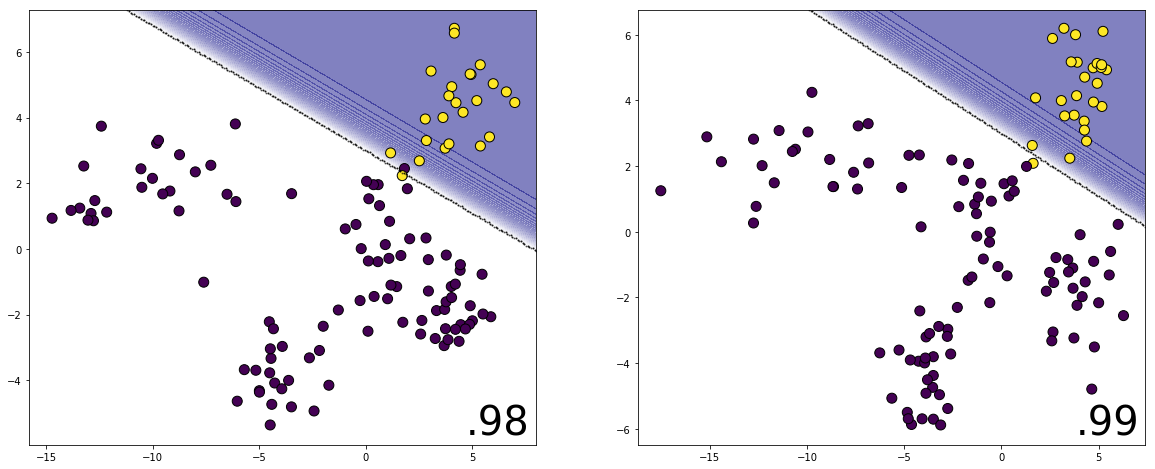

89536/90000 [============================>.] - ETA: 0s

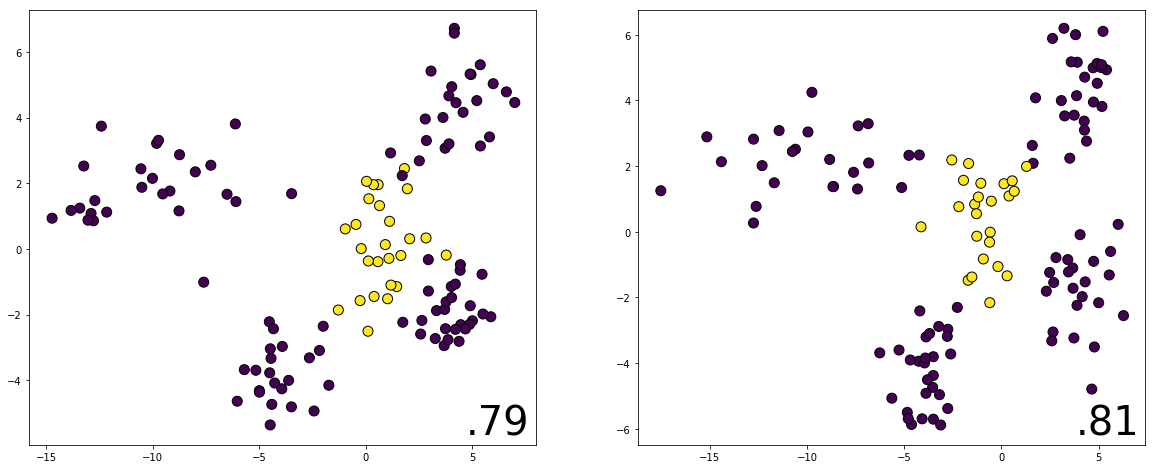

89760/90000 [============================>.] - ETA: 0s

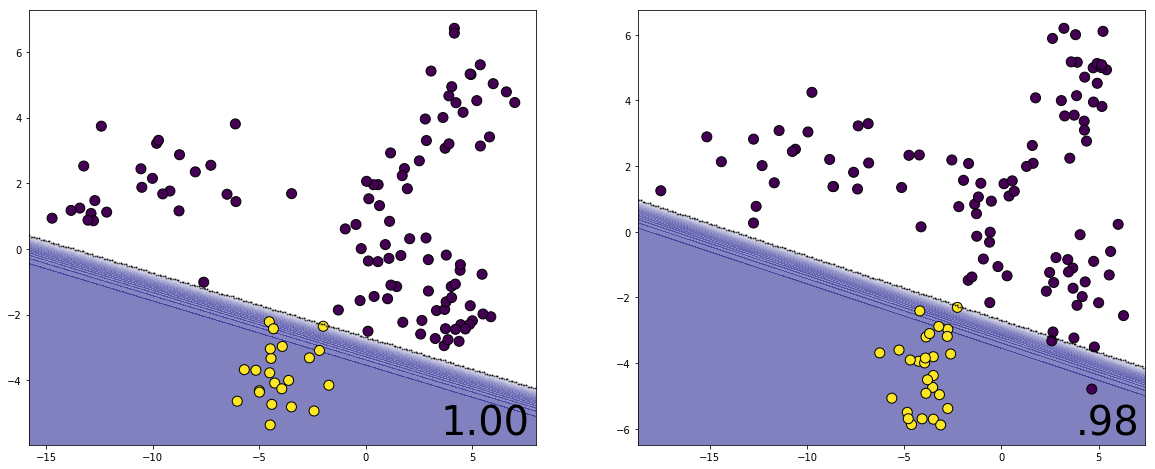

89216/90000 [============================>.] - ETA: 0s

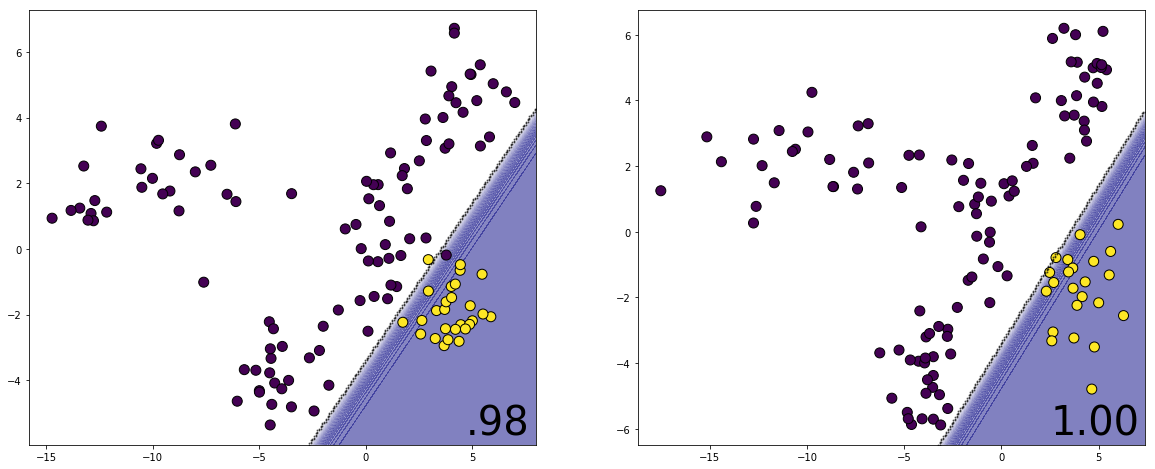

87904/90000 [============================>.] - ETA: 0s

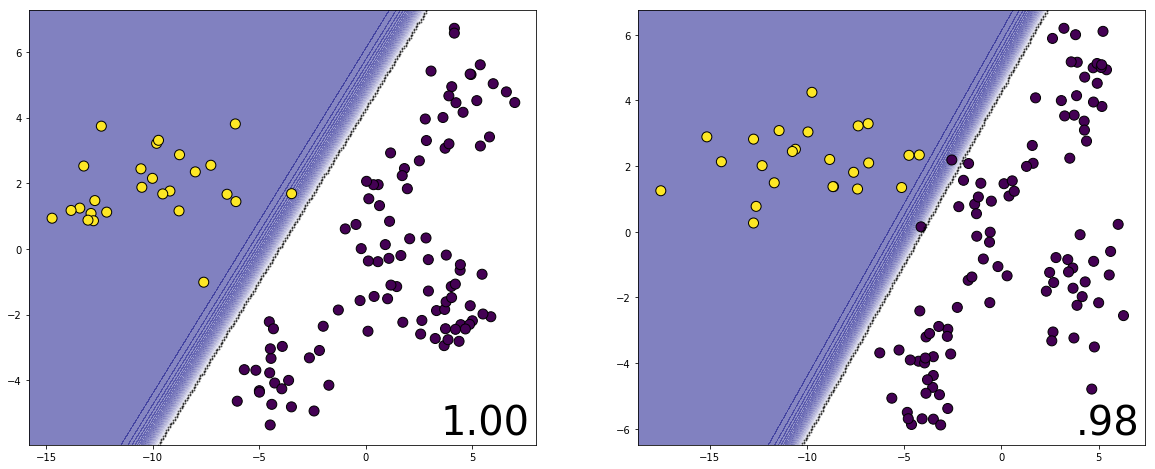

In [80]:
for rv_sel in range(y_train_cat.shape[1]):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
    score_train = models_vs_rest[rv_sel].evaluate(X_train, y_train_cat[:,rv_sel])[1]
    score_test = models_vs_rest[rv_sel].evaluate(X_test, y_test_cat[:,rv_sel])[1]
    MH.plot_MC_boundaries_keras(X_train, y_train_cat[:,rv_sel], score_train, models_vs_rest[rv_sel].predict_proba, normalize = False, ax=ax1)
    MH.plot_MC_boundaries_keras(X_test, y_test_cat[:,rv_sel], score_test, models_vs_rest[rv_sel].predict_proba, normalize = False, ax=ax2)
    plt.show()

- Recordar que el umbral es donde la probabilidad es 0.5.
- De la recta para un lado es mas probable que sea la clase analizada que alguna del resto de las clases, y viceverza

### Superponemos todas las soluciones

87872/90000 [============================>.] - ETA: 0s

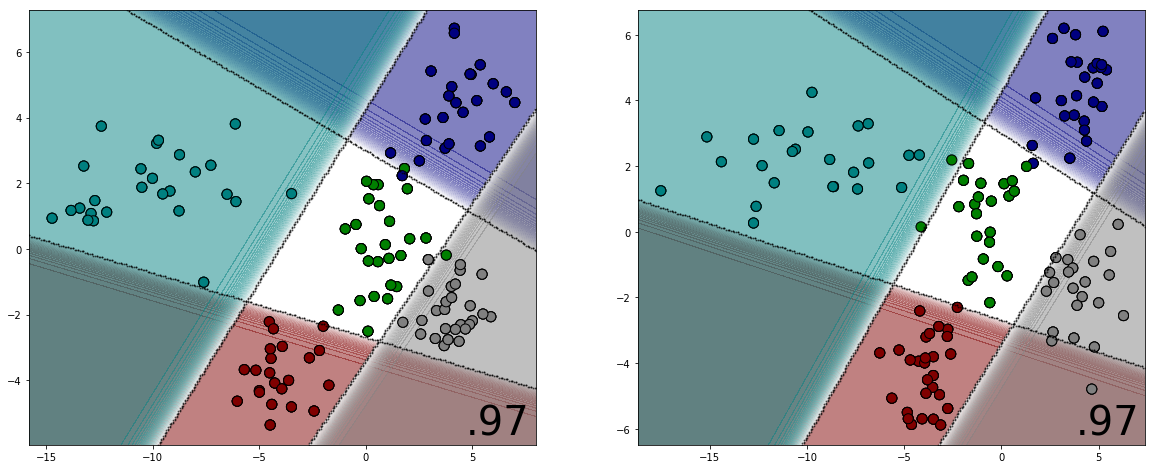

In [81]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
score_train = evaluate_proba_one_rest(X_train, y_train)
score_test = evaluate_proba_one_rest(X_test, y_test)
MH.plot_MC_boundaries_keras(X_train, y_train, score_train, predict_proba_one_rest, normalize = False,  ax=ax1)
MH.plot_MC_boundaries_keras(X_test, y_test, score_test, predict_proba_one_rest, normalize = False,  ax=ax2)
plt.show()

In [82]:
# Esta función calcula la P contra cada modelo y la devuleve como vector
print(np.round(predict_proba_one_rest(X_train, verbose=0)[:5]*100)/100)

[[ 0.    0.25  0.03  0.81  0.  ]
 [ 0.    0.33  0.    1.    0.  ]
 [ 0.01  0.23  0.    0.    0.  ]
 [ 1.    0.29  0.    0.    0.  ]
 [ 0.03  0.21  0.    0.    0.  ]]


In [83]:
# Verificamos que no suman 1 como es de esperar
print(predict_proba_one_rest(X_train, verbose=0)[:5].sum(axis=1))

[ 1.08248418  1.32590662  0.24159267  1.29410262  0.23687425]


### Graficamos superponiendo y normalizando

$\large \frac{p_j}{\sum_i{p_i}} = 0.5$

87712/90000 [============================>.] - ETA: 0s

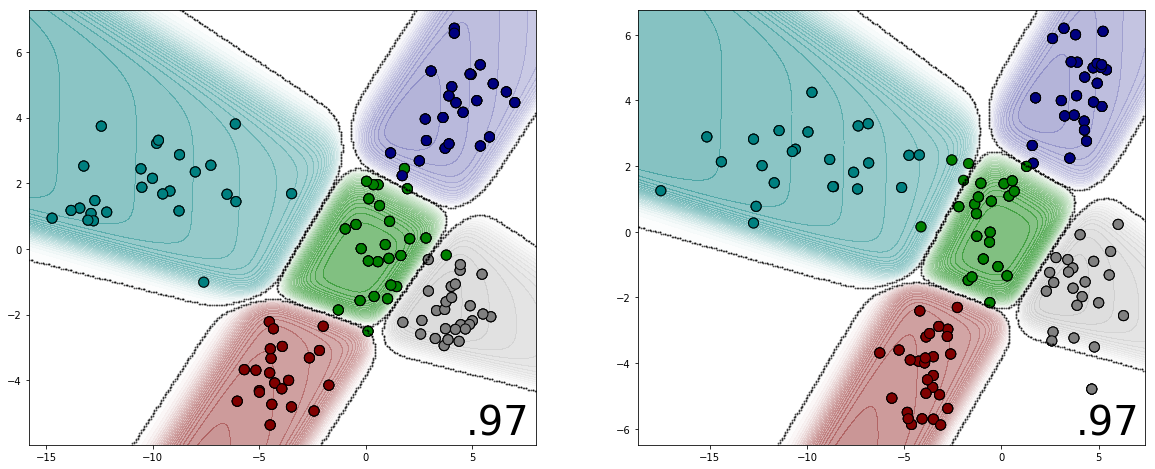

In [84]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
score_train = evaluate_proba_one_rest(X_train, y_train)
score_test = evaluate_proba_one_rest(X_test, y_test)
MH.plot_MC_boundaries_keras(X_train, y_train, score_train, predict_proba_one_rest, normalize = True,  ax=ax1)
MH.plot_MC_boundaries_keras(X_test, y_test, score_test, predict_proba_one_rest, normalize = True, ax=ax2)
plt.show()

- Notar que zonas que estaban en blanco por que la probabilidad era menor a 0.5 para todos los modelos, ahora ya no estan en blanco.
- En el centro aparece la Clase 2 por que su pendiente era muy chica y entonces ahora es el maximo
- Las zonas en blanco que quedan se deben a que la probabilidad de ninguna de las clases es mayor a 0.5

### Ejemplo de "zonas en blanco"

In [86]:
X1 = -15
X2 = -4
point = np.array([X1, X2]).reshape(1,2)
predicted = predict_proba_one_rest(point, verbose=0)
print(np.round(predicted*100)/100)
print('Normalizando:')
suma = predicted.sum()
print(np.round(predicted/suma*100)/100)

[[ 0.    0.04  1.    0.    1.  ]]
Normalizando:
[[ 0.    0.02  0.49  0.    0.49]]


### Grafico clases en el plano

$(X_1, X_2) \in C_j \iff argmax_i(p_i) = j$

In [44]:
def predict_class_one_rest(X):
    return to_categorical(np.argmax(predict_proba_one_rest(X), axis=1))

88480/90000 [============================>.] - ETA: 0s

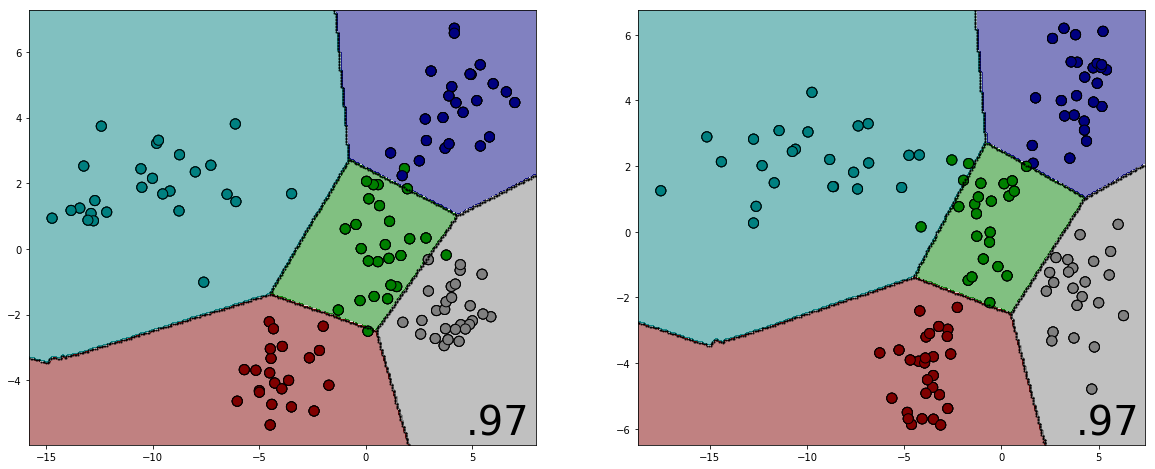

In [87]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
score_train = evaluate_proba_one_rest(X_train, y_train)
score_test = evaluate_proba_one_rest(X_test, y_test)
MH.plot_MC_boundaries_keras(X_train, y_train, score_train, predict_class_one_rest, normalize = False, ax=ax1)
MH.plot_MC_boundaries_keras(X_test, y_test, score_test, predict_class_one_rest, normalize = False,  ax=ax2)
plt.show()

## Red Neuronal

In [175]:
input_features = 2
hidden_units = 2
lambd = 0 #0.001
lr = 0.04 
batch_size = 20
epochs = 200
#selectedOptimizer = optimizers.SGD(lr=lr)
selectedOptimizer = optimizers.adam(lr=lr)

models_vs_rest_nn = []
for i in range(y_train_cat.shape[1]):
    plot_losses = PlotLosses(plot_interval=50, 
                         evaluate_interval=None, 
                         x_val=X_test, 
                         y_val_categorical=y_test_cat[:,i])
    model_vs_rest_nn = Sequential()
    model_vs_rest_nn.add(Dense(hidden_units,input_dim=input_features, kernel_regularizer=regularizers.l2(lambd), name="Capa_Oculta"))
    model_vs_rest_nn.add(Activation('sigmoid', name="sigmoid"))
    model_vs_rest_nn.add(Dense(1, kernel_regularizer=regularizers.l2(lambd)))
    model_vs_rest_nn.add(Activation('sigmoid'))
    model_vs_rest_nn.compile(loss = 'binary_crossentropy', optimizer=selectedOptimizer, metrics=['accuracy'])
    models_vs_rest_nn.append(model_vs_rest_nn)

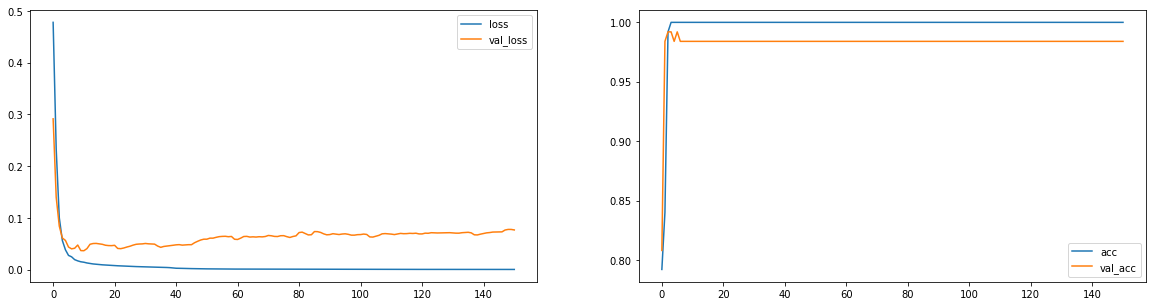

In [176]:
for i in range(y_test_cat.shape[1]):
    models_vs_rest_nn[i].fit(X_train, 
              y_train_cat[:,i], 
              batch_size = batch_size,
              epochs=epochs, 
              verbose=0, 
              validation_data=(X_test, y_test_cat[:,i]), 
              callbacks=[plot_losses],
             )

88800/90000 [============================>.] - ETA: 0s

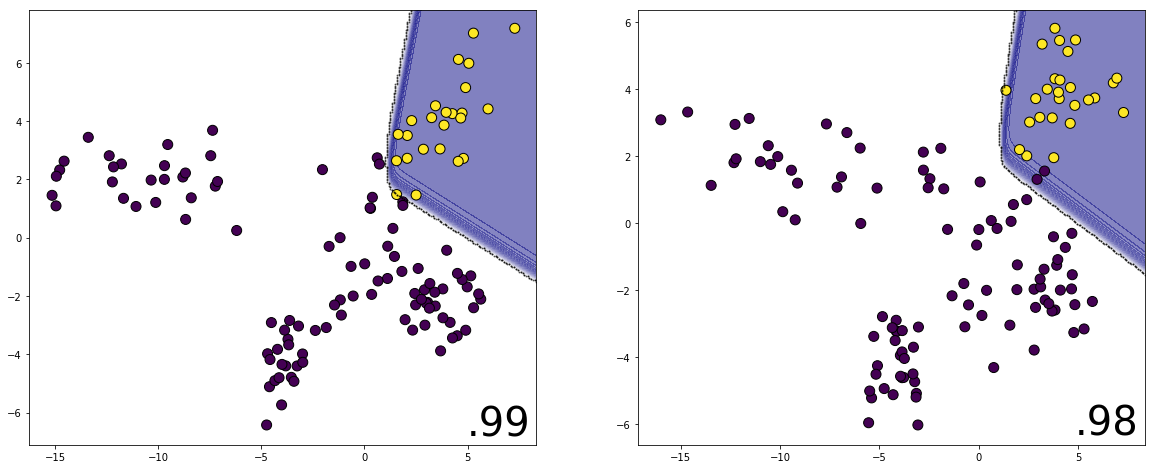

89440/90000 [============================>.] - ETA: 0s

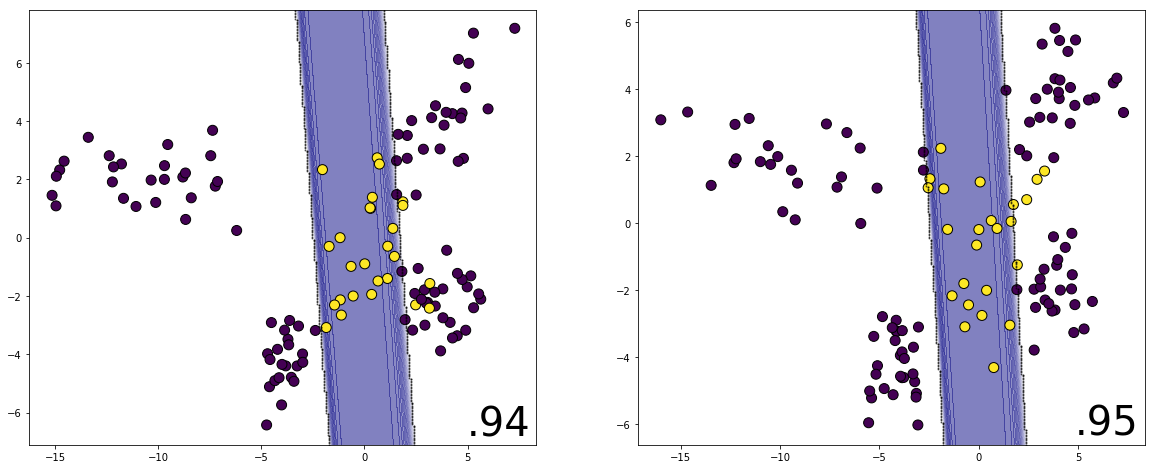

88704/90000 [============================>.] - ETA: 0s

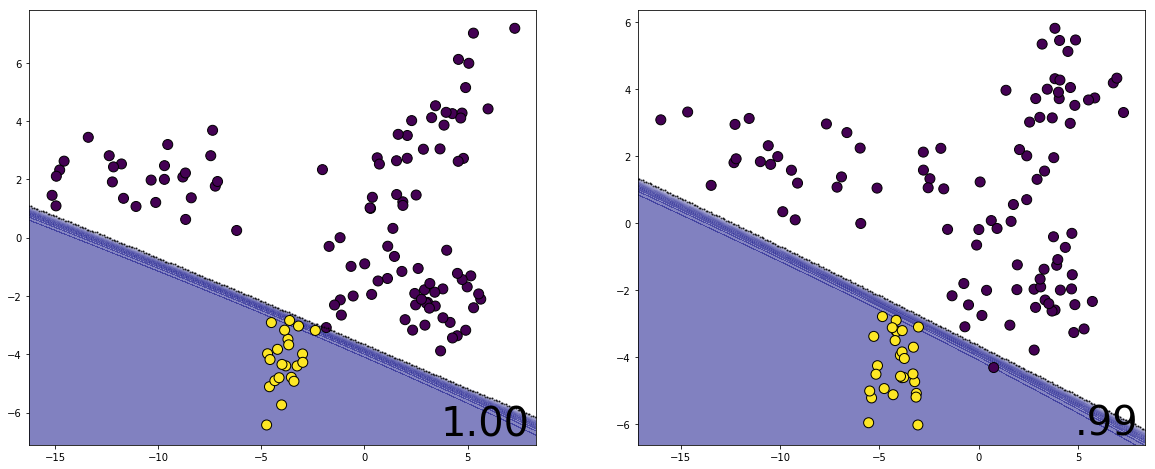

88736/90000 [============================>.] - ETA: 0s

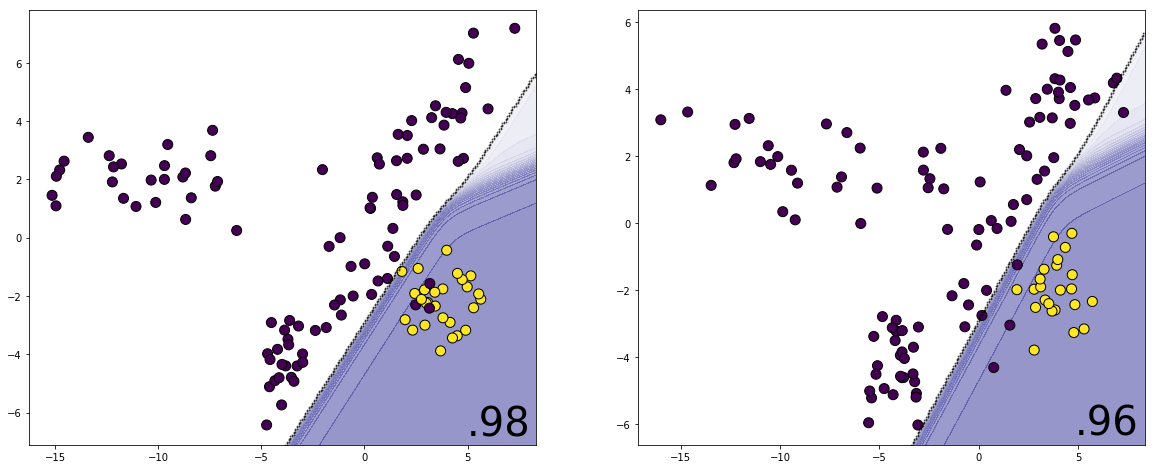

88640/90000 [============================>.] - ETA: 0s

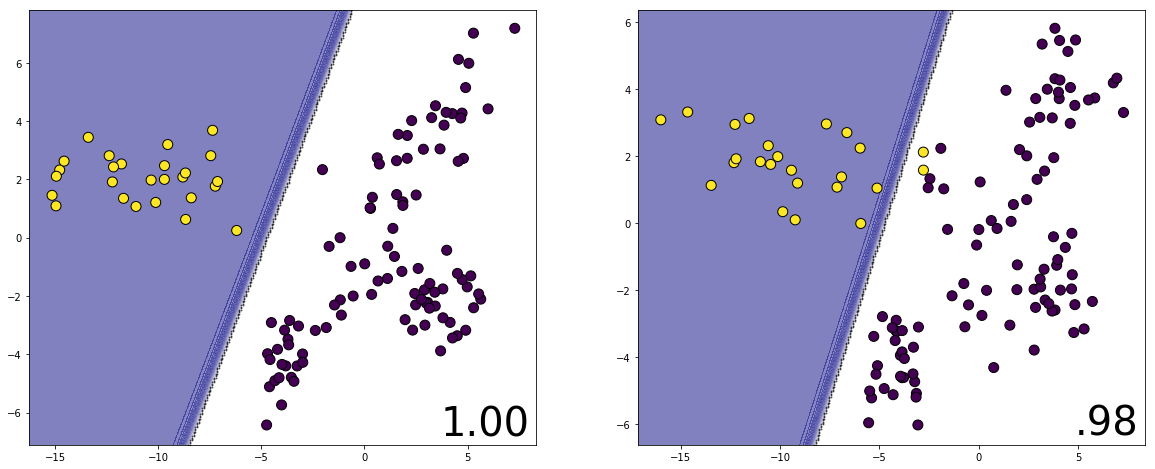

In [177]:
for rv_sel in range(y_train_cat.shape[1]):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
    score_train = models_vs_rest_nn[rv_sel].evaluate(X_train, y_train_cat[:,rv_sel])[1]
    score_test = models_vs_rest_nn[rv_sel].evaluate(X_test, y_test_cat[:,rv_sel])[1]
    MH.plot_MC_boundaries_keras(X_train, y_train_cat[:,rv_sel], score_train, models_vs_rest_nn[rv_sel].predict_proba, normalize = False,  ax=ax1)
    MH.plot_MC_boundaries_keras(X_test, y_test_cat[:,rv_sel], score_test, models_vs_rest_nn[rv_sel].predict_proba, normalize = False,  ax=ax2)
    plt.show()

In [178]:
def predict_proba_one_rest_nn(X, verbose=1):
    proba = np.array([]).reshape(X.shape[0], 0)
    for model in models_vs_rest_nn:
        out = model.predict_proba(X, verbose=verbose)
        proba = np.hstack([proba, out])
    return proba

def evaluate_proba_one_rest_nn(X, y):
    return np.sum(np.argmax(predict_proba_one_rest_nn(X), axis = 1) == y)/len(y)

88736/90000 [============================>.] - ETA: 0s

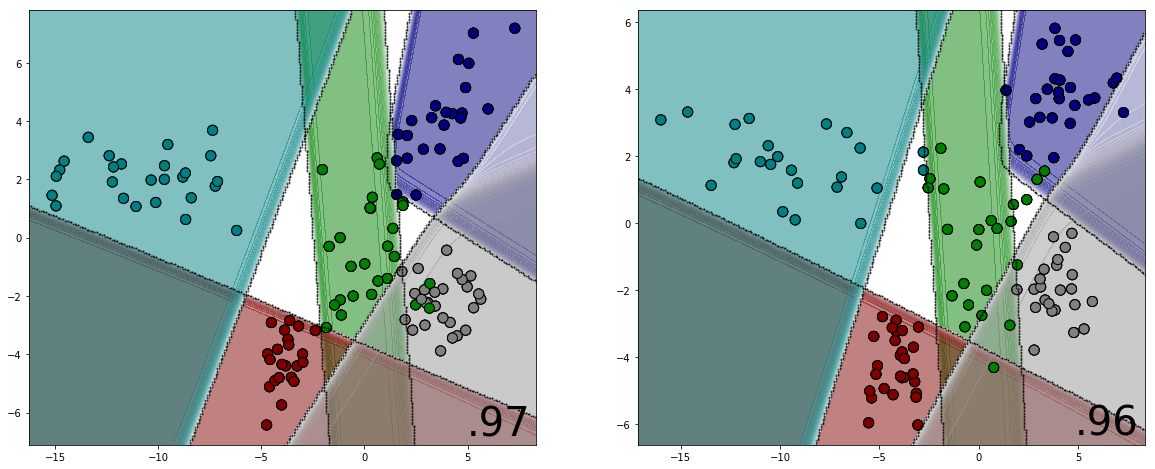

In [179]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
score_train = evaluate_proba_one_rest_nn(X_train, y_train)
score_test = evaluate_proba_one_rest_nn(X_test, y_test)
MH.plot_MC_boundaries_keras(X_train, y_train, score_train, predict_proba_one_rest_nn, normalize = False,  ax=ax1)
MH.plot_MC_boundaries_keras(X_test, y_test, score_test, predict_proba_one_rest_nn, normalize = False,  ax=ax2)
plt.show()

88992/90000 [============================>.] - ETA: 0s

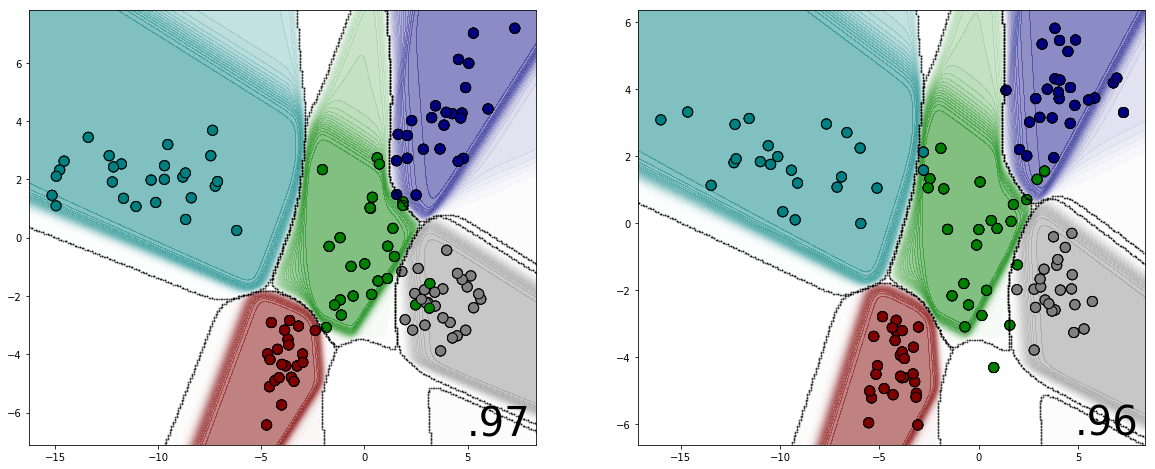

In [180]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
score_train = evaluate_proba_one_rest_nn(X_train, y_train)
score_test = evaluate_proba_one_rest_nn(X_test, y_test)
MH.plot_MC_boundaries_keras(X_train, y_train, score_train, predict_proba_one_rest_nn, normalize = True,  ax=ax1)
MH.plot_MC_boundaries_keras(X_test, y_test, score_test, predict_proba_one_rest_nn, normalize = True,  ax=ax2)
plt.show()

In [181]:
X1 = -2.9
X2 = -0.6
point = np.array([X1, X2]).reshape(1,2)
predicted = predict_proba_one_rest_nn(point, verbose=0)
print(np.round(predicted*100)/100)
print('Normalizando:')
suma = predicted.sum()
print(np.round(predicted/suma*100)/100)

[[ 0.    0.02  0.    0.    0.  ]]
Normalizando:
[[ 0.    0.97  0.01  0.    0.02]]


### Clases en el plano

In [182]:
def predict_class_one_rest_nn(X):
    return to_categorical(np.argmax(predict_proba_one_rest_nn(X), axis=1))

89536/90000 [============================>.] - ETA: 0s

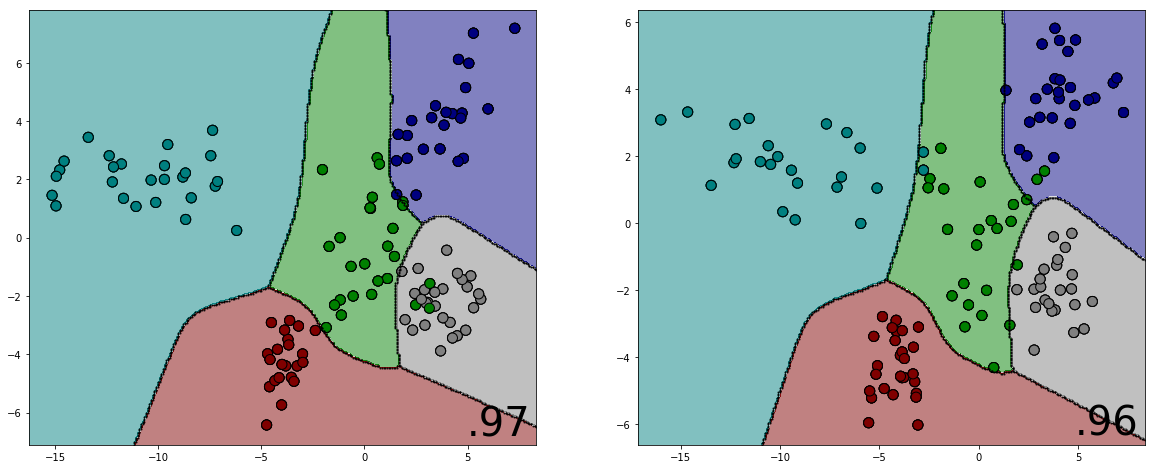

In [183]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
score_train = evaluate_proba_one_rest_nn(X_train, y_train)
score_test = evaluate_proba_one_rest_nn(X_test, y_test)
MH.plot_MC_boundaries_keras(X_train, y_train, score_train, predict_class_one_rest_nn, normalize = True, ax=ax1)
MH.plot_MC_boundaries_keras(X_test, y_test, score_test, predict_class_one_rest_nn, normalize = True, ax=ax2)
plt.show()

# Modelo con C sigmoideas donde C es la cantidad de Clases

## Regresión logistica

$J = \sum_i{J_i} = \sum_i{p_i  \log(\hat{p}_i) + (1-p_i) \log(1-\hat{p}_i)}$  

donde: 
- $p_i$ solo puede valer 1 o 0. Vale 1 si pertenece a la clase $i$'esima, y 0 si no pertenece
- $\hat{p}_i$ es la estimación de la probabilidad

$\hat{y}_i = w_{i,0} + w_{i,1} X_0 + w_{i,2} X_1 $  

$\large \hat{p}_i = \frac{1}{1+e^{-\hat{y}_i}} = \sigma(\hat{y}_i)$

$X_i$'s son los features

para regresión logística es equivalente al "One vs Rest":

$\large \frac{\delta J}{w_{i,j}} = \frac{\delta J_i}{w_{i,j}}$

$\large w_{i,j} = w_{i,j} - \alpha\frac{\delta J_i}{w_{i,j}}$

In [184]:
output_size = y_train_cat.shape[1]
input_features = 2
lambd = 0 #0.001

model_sig_log = Sequential()
model_sig_log.add(Dense(output_size,input_dim=input_features, kernel_regularizer=regularizers.l2(lambd), name="Capa_Oculta"))
model_sig_log.add(Activation('sigmoid', name="sigmoid"))
model_sig_log.summary()


lr = 0.04 
batch_size = 20
epochs = 500

#selectedOptimizer = optimizers.SGD(lr=lr)
selectedOptimizer = optimizers.adam(lr=lr)

# Lo compilo, notar que en vez de binary_crossentropy va categorical_crossentropy
model_sig_log.compile(loss = 'binary_crossentropy', optimizer=selectedOptimizer, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Capa_Oculta (Dense)          (None, 5)                 15        
_________________________________________________________________
sigmoid (Activation)         (None, 5)                 0         
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________


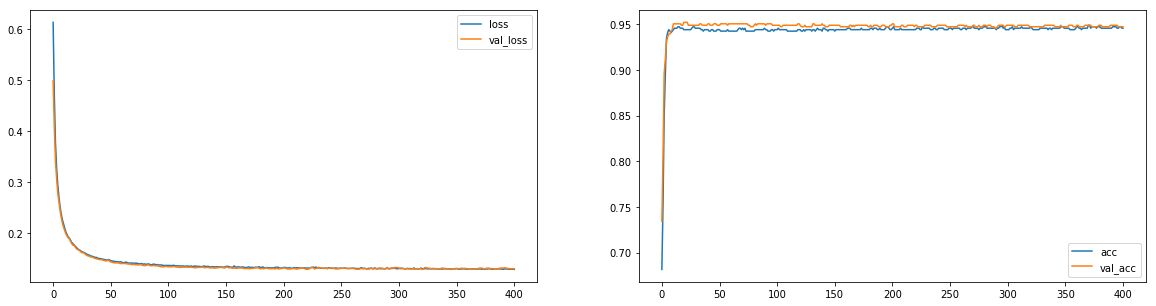

In [185]:
plot_losses = PlotLosses(plot_interval=100, 
                         evaluate_interval=None, 
                         x_val=X_test, 
                         y_val_categorical=y_test_cat)
model_sig_log.fit(X_train, 
          y_train_cat, 
          batch_size = batch_size,
          epochs=epochs, 
          verbose=0, 
          validation_data=(X_test, y_test_cat), 
          callbacks=[plot_losses],
         )

89792/90000 [============================>.] - ETA: 0s

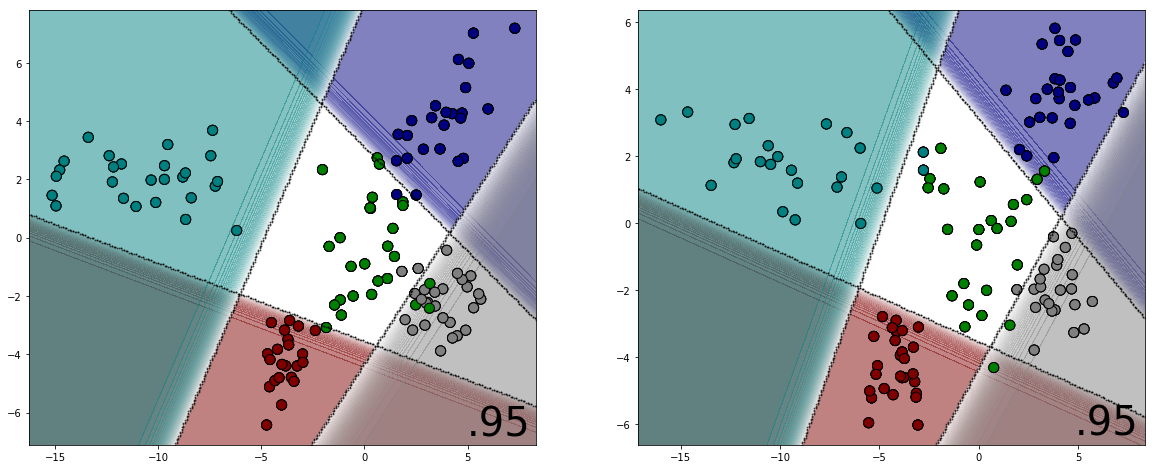

In [186]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
score_train = model_sig_log.evaluate(X_train, y_train_cat)
score_test = model_sig_log.evaluate(X_test, y_test_cat)
MH.plot_MC_boundaries_keras(X_train, y_train, score_train[1], model_sig_log.predict_proba, normalize = False, ax=ax1)
MH.plot_MC_boundaries_keras(X_test, y_test, score_test[1], model_sig_log.predict_proba, normalize = False,  ax=ax2)
plt.show()

88736/90000 [============================>.] - ETA: 0s

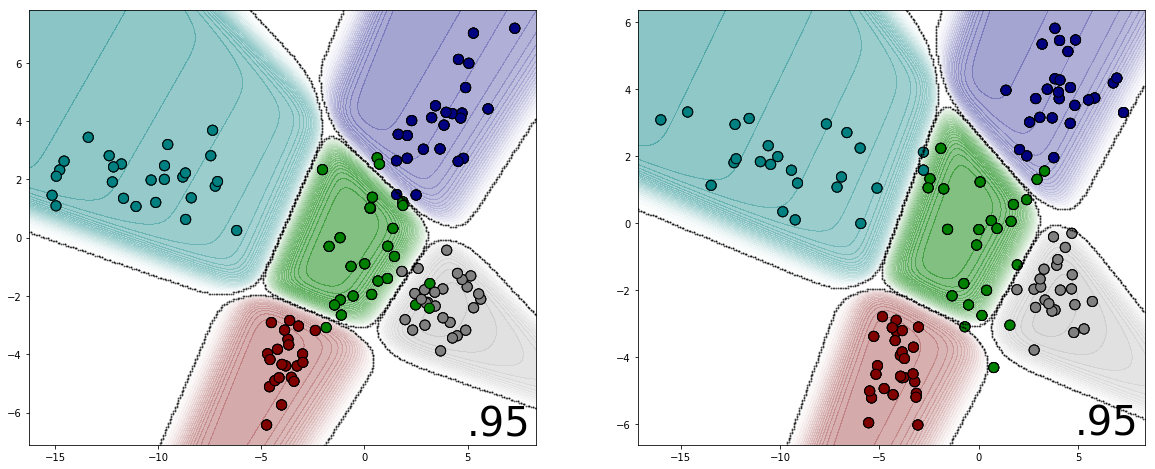

In [187]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
score_train = model_sig_log.evaluate(X_train, y_train_cat)
score_test = model_sig_log.evaluate(X_test, y_test_cat)
MH.plot_MC_boundaries_keras(X_train, y_train, score_train[1], model_sig_log.predict_proba, normalize = True,  ax=ax1)
MH.plot_MC_boundaries_keras(X_test, y_test, score_test[1], model_sig_log.predict_proba, normalize = True,  ax=ax2)
plt.show()

## Red Neuronal de 1 capa oculta

$J = \sum_i{J_i} = \sum_i{p_i  \log(\hat{p}_i) + (1-p_i) \log(1-\hat{p}_i)}$  

donde: 
- $p_i$ solo puede valer 1 o 0. Vale 1 si pertenece a la clase $i$'esima, y 0 si no pertenece
- $\hat{p}_i$ es la estimación de la probabilidad

Supongamos 3 neuronas en la capa intermedia donde $a_k$ son las salidas

$\hat{y}_i = w_{i,0}^h + w_{i,1}^h a_1 + w_{i,2}^h a_2 +  w_{i,3}^h a_3$  

$\large \hat{p}_i = \frac{1}{1+e^{-\hat{y}_i}} = \sigma(\hat{y}_i)$

$X_i$'s son los features

$a_k = w_{k,0} + w_{k,1} X_0 + w_{k,2} X_1 $  

$\large \frac{\delta J}{\delta w_{k,j}} = \sum{\frac{\delta J_i}{\delta w_{k,j}}}$

$\large \frac{\delta J_i}{\delta w_{k,j}} = \frac{\delta J_i}{\delta \hat{p}_i} \frac{\delta \hat{p}_i}{\delta \hat{y}_i} \frac{\delta \hat{y}_i}{\delta a_{k}} \frac{\delta a_k}{\delta w_{k,j}}$

Notar que para cualquier i, la derivada contra cualquiera k es distinta de cero y depende de los pesos que conectan la capa intermedia con la salida

Por lo tanto a los pesos de la primer capa, los estaran ajustando cada una de las i clases, intentando llevarlo hacia su lugar

Como conclusión, es probable que se necesiten mas unidades en la capa intermedia que en el caso de modelos independientes

In [188]:
hidden_units = 4
lambd = 0 #0.001
model_sig_nn = Sequential()
model_sig_nn.add(Dense(hidden_units,input_dim=input_features, kernel_regularizer=regularizers.l2(lambd), name="Capa_Oculta"))
model_sig_nn.add(Activation('sigmoid', name="sigmoid"))
model_sig_nn.add(Dense(output_size, name="Salida"))
model_sig_nn.add(Activation('sigmoid', name="output")) 
model_sig_nn.summary()


lr = 0.04 
batch_size = 20
epochs = 1000

#selectedOptimizer = optimizers.SGD(lr=lr)
selectedOptimizer = optimizers.adam(lr=lr)

# Lo compilo, notar que en vez de binary_crossentropy va categorical_crossentropy
model_sig_nn.compile(loss = 'binary_crossentropy', optimizer=selectedOptimizer, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Capa_Oculta (Dense)          (None, 4)                 12        
_________________________________________________________________
sigmoid (Activation)         (None, 4)                 0         
_________________________________________________________________
Salida (Dense)               (None, 5)                 25        
_________________________________________________________________
output (Activation)          (None, 5)                 0         
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


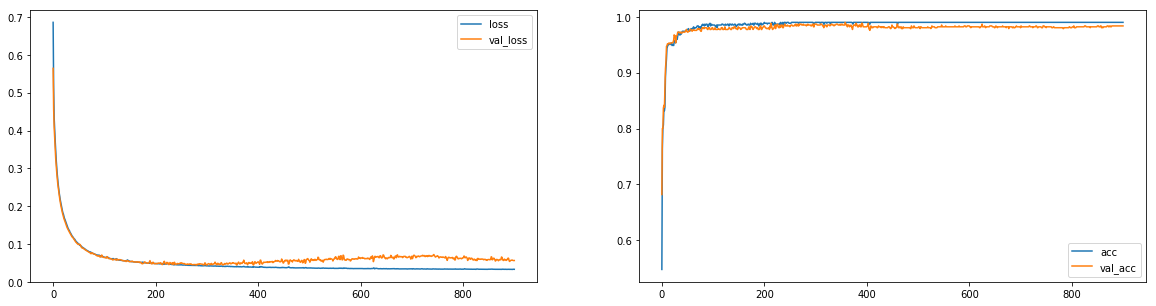

In [189]:
plot_losses = PlotLosses(plot_interval=100, 
                         evaluate_interval=None, 
                         x_val=X_test, 
                         y_val_categorical=y_test_cat)
model_sig_nn.fit(X_train, 
          y_train_cat, 
          batch_size = batch_size,
          epochs=epochs, 
          verbose=0, 
          validation_data=(X_test, y_test_cat), 
          callbacks=[plot_losses],
         )

89280/90000 [============================>.] - ETA: 0s

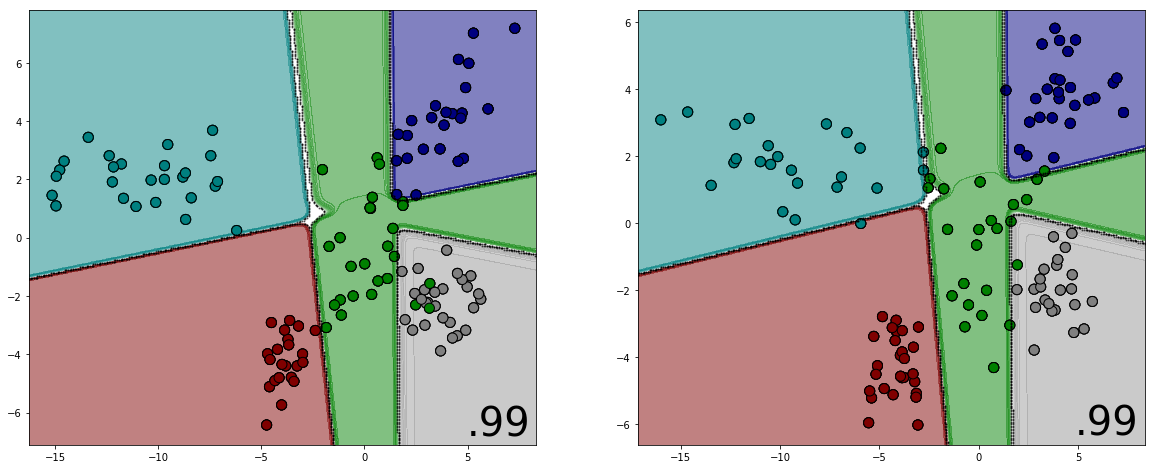

In [190]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
score_train = model_sig_nn.evaluate(X_train, y_train_cat)
score_test = model_sig_nn.evaluate(X_test, y_test_cat)
MH.plot_MC_boundaries_keras(X_train, y_train, score_train[1], model_sig_nn.predict_proba, normalize = False, mesh_res = 300, ax=ax1)
MH.plot_MC_boundaries_keras(X_test, y_test, score_test[1], model_sig_nn.predict_proba, normalize = False, mesh_res = 300, ax=ax2)
plt.show()

89600/90000 [============================>.] - ETA: 0s

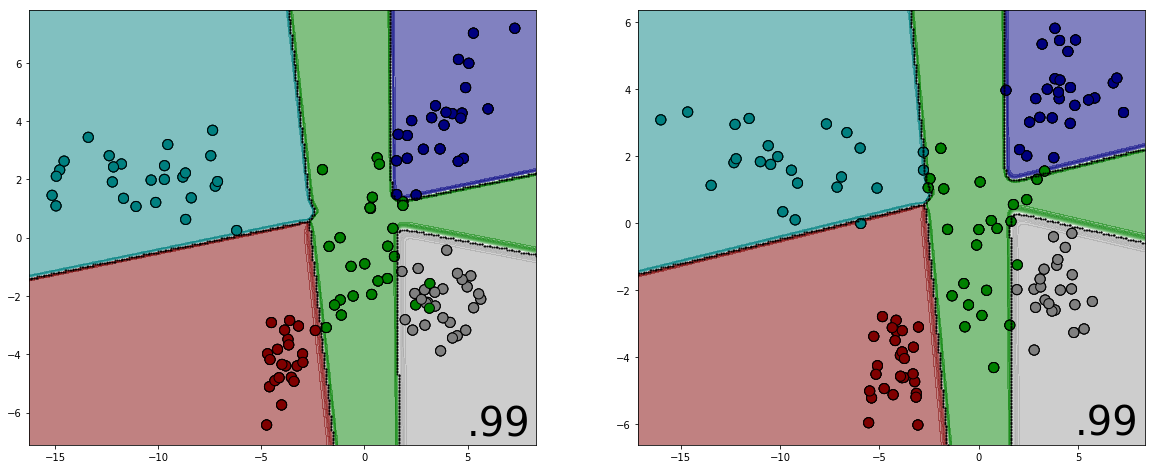

In [191]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
score_train = model_sig_nn.evaluate(X_train, y_train_cat)
score_test = model_sig_nn.evaluate(X_test, y_test_cat)
MH.plot_MC_boundaries_keras(X_train, y_train, score_train[1], model_sig_nn.predict_proba, normalize = True, mesh_res = 300, ax=ax1)
MH.plot_MC_boundaries_keras(X_test, y_test, score_test[1], model_sig_nn.predict_proba, normalize = True, mesh_res = 300, ax=ax2)
plt.show()

### Clases en el plano

In [192]:
def predict_class_sig_nn(X):
    return to_categorical(np.argmax(model_sig_nn.predict_proba(X), axis=1))

89984/90000 [============================>.] - ETA: 0s

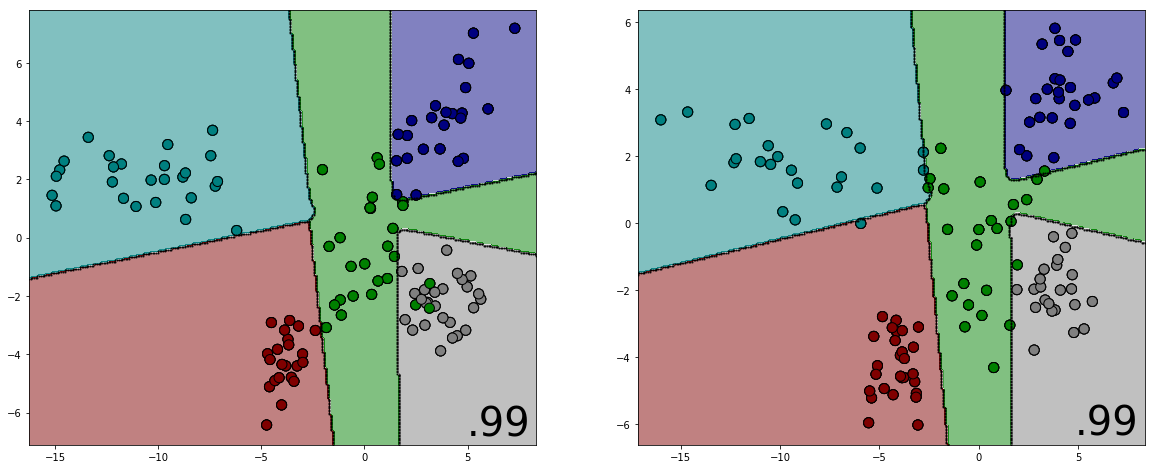

In [193]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
MH.plot_MC_boundaries_keras(X_train, y_train, score_train[1], predict_class_sig_nn, normalize = False, ax=ax1)
MH.plot_MC_boundaries_keras(X_test, y_test, score_test[1], predict_class_sig_nn, normalize = False, ax=ax2)
plt.show()

Comentarios:
- Tanto en one vs rest como en sigmoideas, la probabilidad de la que partimos es 0.5 por cada salida

# Modelo con Softmax

## Regresión logística

In [194]:
input_features = 2
hidden_units = 20
output_size = y_train_cat.shape[1]
model_sm_log = Sequential()
model_sm_log.add(Dense(output_size,input_dim=input_features, kernel_regularizer=regularizers.l2(lambd), name="Capa_Oculta"))
model_sm_log.add(Activation('softmax', name="softmax")) # Notar que en vez de sigmoidea es softmax
model_sm_log.summary()

lambd = 0 #0.001
lr = 0.04 
batch_size = 20
epochs = 500

#selectedOptimizer = optimizers.SGD(lr=lr)
selectedOptimizer = optimizers.adam(lr=lr)

# Lo compilo, notar que en vez de binary_crossentropy va categorical_crossentropy
model_sm_log.compile(loss = 'categorical_crossentropy', optimizer=selectedOptimizer, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Capa_Oculta (Dense)          (None, 5)                 15        
_________________________________________________________________
softmax (Activation)         (None, 5)                 0         
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________


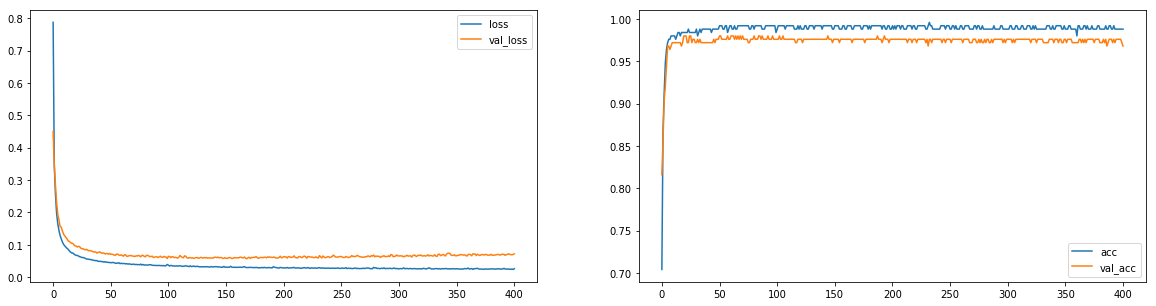

In [51]:
plot_losses = PlotLosses(plot_interval=100, 
                         evaluate_interval=None, 
                         x_val=X_test, 
                         y_val_categorical=y_test_cat)
model_sm_log.fit(X_train, 
          y_train_cat, 
          batch_size = batch_size,
          epochs=epochs, 
          verbose=0, 
          validation_data=(X_test, y_test_cat), 
          callbacks=[plot_losses],
         )

88480/90000 [============================>.] - ETA: 0s

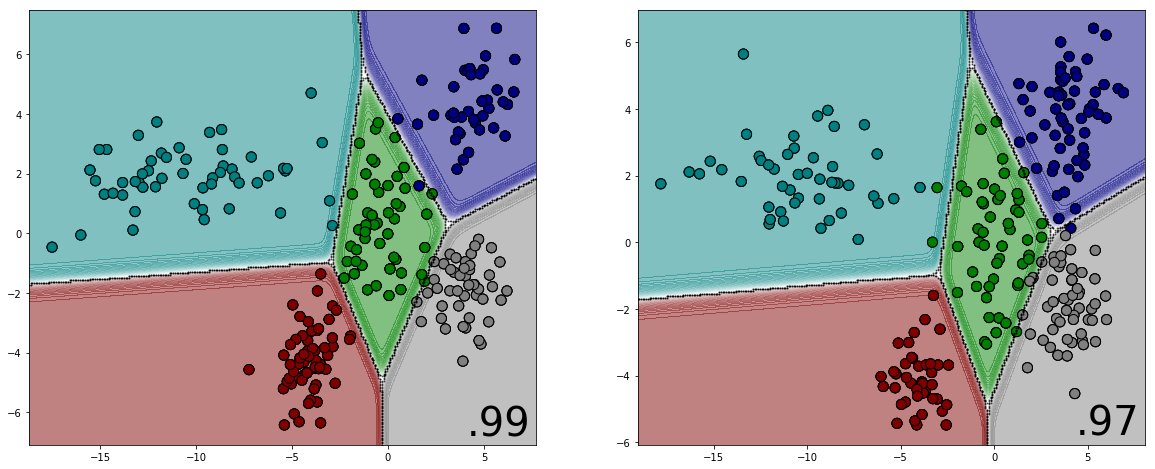

In [52]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
score_train = model_sm_log.evaluate(X_train, y_train_cat)
score_test = model_sm_log.evaluate(X_test, y_test_cat)
MH.plot_MC_boundaries_keras(X_train, y_train, score_train[1], model_sm_log.predict_proba, ax=ax1)
MH.plot_MC_boundaries_keras(X_test, y_test, score_test[1], model_sm_log.predict_proba, ax=ax2)
plt.show()

In [53]:
def predict_class_softmax(X):
    return to_categorical(np.argmax(model_sm_log.predict_proba(X), axis=1))

88960/90000 [============================>.] - ETA: 0s

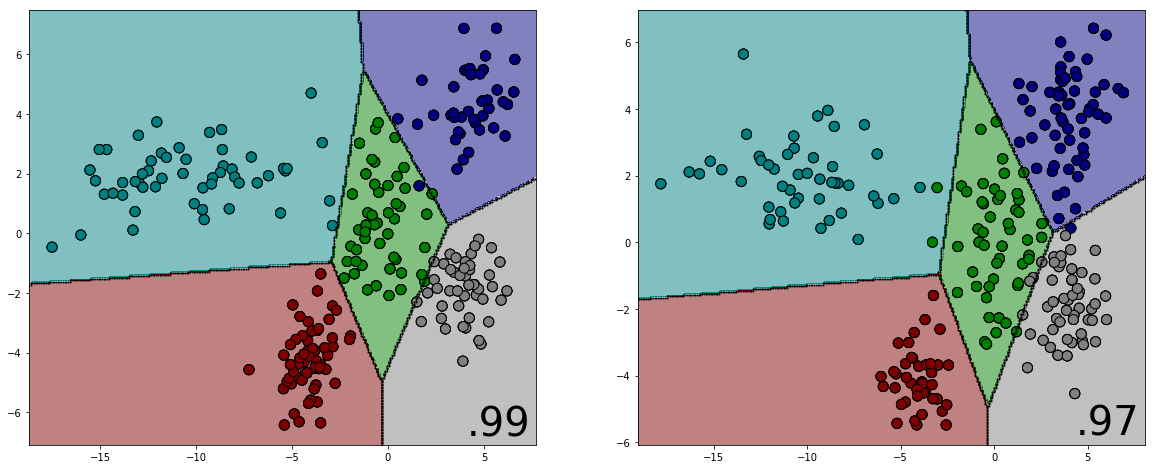

In [54]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
score_train = model_sm_log.evaluate(X_train, y_train_cat)
score_test = model_sm_log.evaluate(X_test, y_test_cat)
MH.plot_MC_boundaries_keras(X_train, y_train, score_train[1], predict_class_softmax,  ax=ax1)
MH.plot_MC_boundaries_keras(X_test, y_test, score_test[1], predict_class_softmax, ax=ax2)
plt.show()

## Red neuronal de 1 capa oculta

In [141]:
input_features = 2
hidden_units = 2
lambd = 0 #0.001
output_size = y_train_cat.shape[1]
model_sm_nn = Sequential()
model_sm_nn.add(Dense(hidden_units,input_dim=input_features, kernel_regularizer=regularizers.l2(lambd), name="Capa_Oculta"))
model_sm_nn.add(Activation('sigmoid', name="sigmoid"))
model_sm_nn.add(Dense(output_size, name="Salida"))
model_sm_nn.add(Activation('softmax', name="softmax")) # Notar que en vez de sigmoidea es softmax
model_sm_nn.summary()


lr = 0.04 
batch_size = 20
epochs = 1000

#selectedOptimizer = optimizers.SGD(lr=lr)
selectedOptimizer = optimizers.adam(lr=lr)

# Lo compilo, notar que en vez de binary_crossentropy va categorical_crossentropy
model_sm_nn.compile(loss = 'categorical_crossentropy', optimizer=selectedOptimizer, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Capa_Oculta (Dense)          (None, 2)                 6         
_________________________________________________________________
sigmoid (Activation)         (None, 2)                 0         
_________________________________________________________________
Salida (Dense)               (None, 5)                 15        
_________________________________________________________________
softmax (Activation)         (None, 5)                 0         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


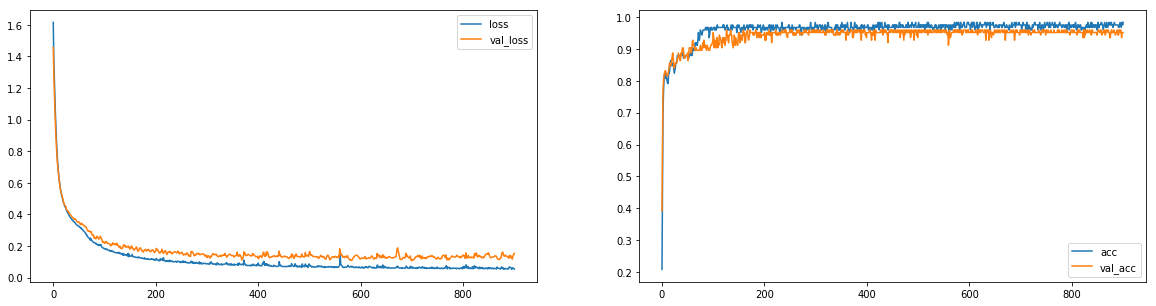

In [142]:
plot_losses = PlotLosses(plot_interval=100, 
                         evaluate_interval=None, 
                         x_val=X_test, 
                         y_val_categorical=y_test_cat)
model_sm_nn.fit(X_train, 
          y_train_cat, 
          batch_size = batch_size,
          epochs=epochs, 
          verbose=0, 
          validation_data=(X_test, y_test_cat), 
          callbacks=[plot_losses],
         )

89120/90000 [============================>.] - ETA: 0s

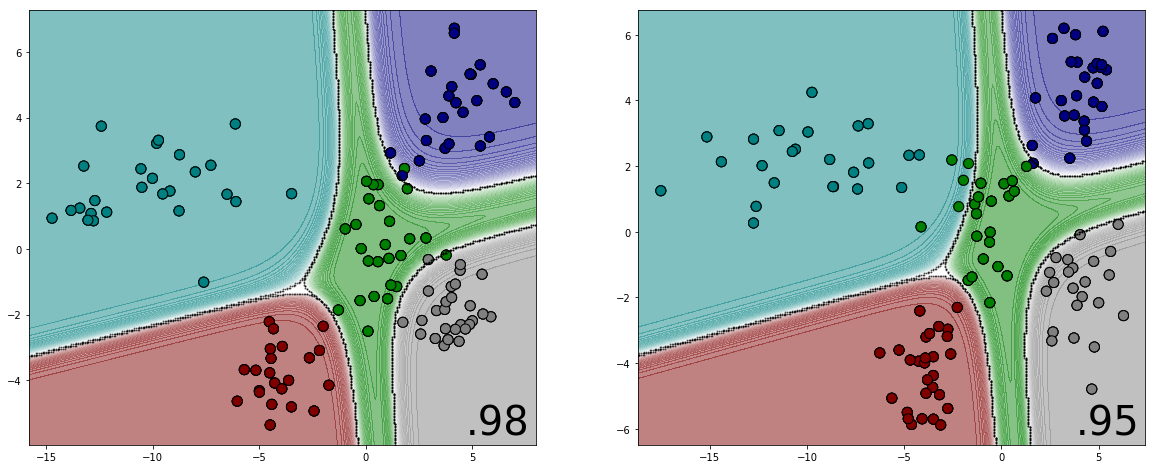

In [143]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
score_train = model_sm_nn.evaluate(X_train, y_train_cat)
score_test = model_sm_nn.evaluate(X_test, y_test_cat)
MH.plot_MC_boundaries_keras(X_train, y_train, score_train[1], model_sm_nn.predict_proba, ax=ax1)
MH.plot_MC_boundaries_keras(X_test, y_test, score_test[1], model_sm_nn.predict_proba, ax=ax2)
plt.show()

### Clases en el plano

In [144]:
def predict_class_softmax_nn(X):
    return to_categorical(np.argmax(model_sm_nn.predict_proba(X), axis=1))

88960/90000 [============================>.] - ETA: 0s

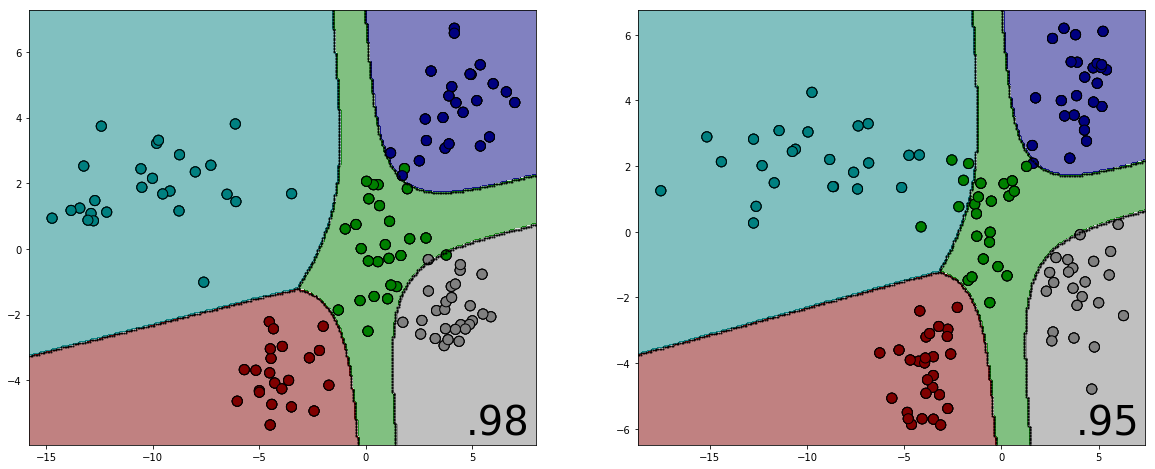

In [145]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
score_train = model_sm_nn.evaluate(X_train, y_train_cat)
score_test = model_sm_nn.evaluate(X_test, y_test_cat)
MH.plot_MC_boundaries_keras(X_train, y_train, score_train[1], predict_class_softmax_nn,mesh_res = 300, ax=ax1)
MH.plot_MC_boundaries_keras(X_test, y_test, score_test[1], predict_class_softmax_nn, mesh_res = 300, ax=ax2)
plt.show()

softmax cross-entropy:  
http://peterroelants.github.io/posts/neural_network_implementation_intermezzo02/